In [1]:
import math
import json
import pandas as pd
import numpy as np
from pylab import *
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

In [2]:
def calc_cost(distance):
    """
    determine the cost of the movement according to the rules:
    Each swing costs the particle $D^-2, where D is the straight-line distance of the length of rope used for that particular swing.
    """
    return pow(distance, -2)

def calc_distance(x1,y1,x2,y2): 
    """
    determine the distance between 2 points on a coordinate plane
    """
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def calc_slope(x1,y1,x2,y2):
    ##(0,0) => (5,0)
    if x1 == x2 and y1 == y2:
        return "NaL"
    elif x1 == x2:
        if y1 < y2:
            return "vertical_pos"
        elif y1 > y2:
            return "vertical_neg"
    elif y1 == y2:
        if x1 < x2:
            return "horizontal_pos"
        elif x1 > x2:
            return "horizontal_neg"
    else:
#         if slope > 0:
#             return str(slope)+"_pos"
#         elif slope < 0:
#             return str(slope)+"_neg"
        slope = (y2-y1)/(x2-x1)
    
    return str(slope)+"_"+quandrant_loc(x1,y1,x2,y2)
    
def plot_path(x1,y1,x2,y2, color="b"):
    # plot points
    ax.plot(x1, y1, color+'o')
    ax.plot(x2, y2, color+'o')
    # plot line
    ax.plot([x1, x2],[y1, y2], color+'-')

def lattice_intercepts(origin, radius):
    x = origin[0]
    y = origin[1]
    r_2 = round(pow(radius,2),1) # rounding to nearest 10th...
    xy_2 = (pow(x,2) + pow(y,2))
    lattice_intercepts = []
    i = 0
    while i <= xy_2:
        j = 0
        while j <= xy_2:
#             print(str(pow((i - x),2) + pow((j - y),2))+" == "+str(r_2))
            if (pow((i - x),2) + pow((j - y),2) == r_2):
                lattice_intercepts.append((i,j))
            j = j + 1
        i = i + 1
    return lattice_intercepts

def calc_angle(p0, p1, p2):
    """
    calculate the angle (in degrees) for vertex p0 p1 p2 
    """
    v0 = np.array(p0) - np.array(p1)
    v1 = np.array(p2) - np.array(p1)
    angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
    return round(np.degrees(angle),4)

def inbounds(origin, thru_pt, distance, slope):

    x = origin[0]
    y = origin[1]
    x_tp = thru_pt[0]
    y_tp = thru_pt[1]
    
    inbounds = True

    if slope == "vertical_pos":
        x1 = x
        y1 = y + distance
        if y1 > 20.5:
            inbounds = False
    elif slope == "vertical_neg":
        x1 = x
        y1 = y - distance
        if y1 < 0.5:
            inbounds = False
    elif slope == "horizontal_pos":
        x1 = x + distance
        y1 = y
        if x1 > 20.5:
            inbounds = False
    elif slope == "horizontal_neg":
        x1 = x - distance
        y1 = y
        if x1 < 0.5:
            inbounds = False
    else:
        slope = float(slope.split("_")[0])
        c = 1/math.sqrt(1+pow(slope,2))
        s = slope/math.sqrt(1+pow(slope,2))

        # QUADRANT 1
        if x < x_tp and y < y_tp:
            x1 = (x+distance*c)
            y1 = (y+distance*s)
        # QUADRANT 2
        elif x < x_tp and y > y_tp:
            x1 = (x+distance*c)
            y1 = (y+distance*s)
        # QUADRANT 3
        elif x > x_tp and y > y_tp:
            x1 = (x-distance*c)
            y1 = (y-distance*s)
        # QUADRANT 4
        elif x > x_tp and y < y_tp:
            x1 = (x-distance*c)
            y1 = (y-distance*s)

        if x1 < 0.5 or x1 > 20.5 or y1 < 0.5 or y1 > 20.5:
            inbounds = False
#     plot_path(x,y,x1,y1,"y")
#     plot_path(x,y,x_tp,y_tp,"c")
    return inbounds

def quandrant_loc(x,y,x1,y1):
    # QUADRANT 1
    if x < x1 and y < y1:
        return "q1"
    # QUADRANT 2
    elif x < x1 and y > y1:
        return "q2"
    # QUADRANT 3
    elif x > x1 and y > y1:
        return "q3"
    # QUADRANT 4
    elif x > x1 and y < y1:
        return "q4"

def recursive_swing(toss,start,v):
    
    g = 180
    d_rem = 0
    stack = (0,0,0,0,0)
    
    for i in graph[(start[0],start[1])]:
        # make sure radius of swing long enough to catch a post and that it doesn't catch the origin
        if start[2] > i[2] and (start[0],start[1]) != (i[0],i[1]):
            g_2 = calc_angle((toss[0],toss[1]),(start[0],start[1]),(i[0],i[1]))
            if v == "pos":
                if g_2 < g: 
                    g = g_2
                    d_rem = start[2] - i[2]
                    stack = (i[0],i[1],d_rem,i[3],g_2)
            if v == "neg":
#                 print("angle: "+str(g_2))
                g = g*-1
                if g_2 > g: 
                    g = g_2
                    d_rem = start[2] - i[2]
                    stack = (i[0],i[1],d_rem,i[3],g_2)
    # find all the lps
    if stack != (0,0,0,0,0) and inbounds((toss[0],toss[1]), (start[0],start[1]), start[2], calc_slope(toss[0],toss[1],start[0],start[1])):
        print("dist: "+str(start[2]))
        lps = lattice_intercepts((stack[0],stack[1]),stack[2]) 
        if len(lps) > 0:
            for l in lps:
                print("has lps")
                x = l[0]
                y = l[1]

                g_bound = calc_angle((toss[0],toss[1]),(start[0],start[1]),(stack[0],stack[1]))
                g_swing = calc_angle((toss[0],toss[1]),(start[0],start[1]),(x,y))
#                 print("angle: "+str(180-abs(g5)))
#                 print("test: "+str(g_test))
#                 if  0 < g_swing < 180-abs(g_bound):
                ax.plot(x,y,'mo')
                plot_path(start[0],start[1],stack[0],stack[1])
                    
        # see if there is more slack...
        if stack[2] > 0:
#             print(" >>> len remain: "+str(stack[2]))
            recursive_swing(start,stack,v) 
    else:
        return []
    
def excel_col(col):
    quot, rem = divmod(col-1,26)
    return excel_col(quot) + chr(rem+ord("A")) if col!=0 else ""

toss: (6.0,8.0) => (17.0,20.0) | d:16.278820596099706 | s:1.0909090909090908_q1
    g_pos_swing: (17.0,20.0) => (8.0,8.0) | d:1.278820596099706 | s:1.3333333333333333_q3 | g:5.6405°
    g_neg_swing: (17.0,20.0) => (12.0,16.0) | d:9.875696358666858 | s:0.8_q3 | g:-8.8297°
    d2: 16.278820596099706
    lps: [(1, 17), (1, 23), (5, 9), (5, 31), (6, 8), (6, 32), (14, 4), (14, 36), (20, 4), (20, 36), (28, 8), (28, 32), (29, 9), (29, 31), (33, 17), (33, 23)]
___________
        positive swing possibilities:
x2: 17.0
        negative swing possibilities:
dist: 9.875696358666858
[('Q20', 'E9')]


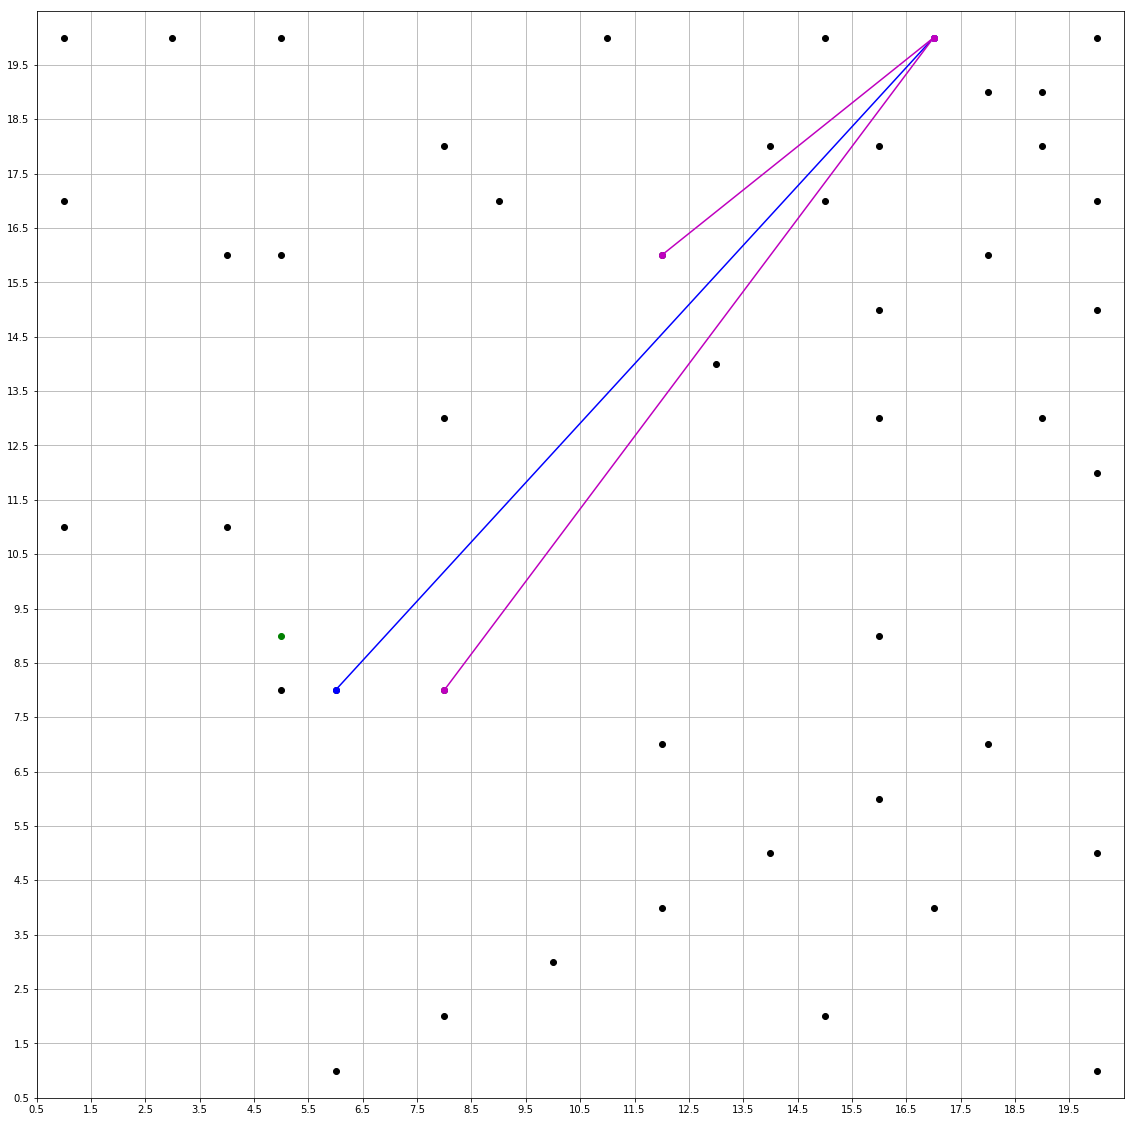

In [8]:
coords = [(6.0, 8.0), (3.0, 20.0), (5.0, 20.0), (11.0, 20.0), (15.0, 20.0), (17.0, 20.0), (20.0, 20.0), (18.0, 19.0), (19.0, 19.0), (8.0, 18.0), (14.0, 18.0), (16.0, 18.0), (19.0, 18.0), (1.0, 17.0), (9.0, 17.0), (15.0, 17.0), (20.0, 17.0), (4.0, 16.0), (5.0, 16.0), (12.0, 16.0), (18.0, 16.0), (16.0, 15.0), (20.0, 15.0), (13.0, 14.0), (8.0, 13.0), (16.0, 13.0), (19.0, 13.0), (20.0, 12.0), (1.0, 11.0), (4.0, 11.0), (16.0, 9.0), (5.0, 8.0), (8.0, 8.0), (12.0, 7.0), (18.0, 7.0), (16.0, 6.0), (14.0, 5.0), (20.0, 5.0), (12.0, 4.0), (17.0, 4.0), (10.0, 3.0), (8.0, 2.0), (15.0, 2.0), (1.0, 20.0), (6.0, 1.0), (20.0, 1.0)]
graph = {} 

figure(figsize=(20,20))
ax=subplot(aspect='equal')
ax.set_xticks(np.arange(.5, 20.5, 1))
ax.set_yticks(np.arange(.5, 20.5, 1))
# ax.set_xticks(np.arange(0, 20, 1))
# ax.set_yticks(np.arange(0, 20, 1))

# plot all coordinates
[ax.plot(i[0], i[1], 'ko') for i in coords]

# ax.plot(4.6098,0.3902, 'go')

# plot start and finish
# ax.fill_between([-.5,.5], -.5, .5, facecolor='yellow')
# ax.fill_between([18.5,19.5], 18.5, 19.5, facecolor='yellow')

# ax.fill_between([15,16], 19, 20, facecolor='red')
# ax.fill_between([16,17], 18, 19, facecolor='red')
# ax.fill_between([17,18], 17, 18, facecolor='red')
# ax.fill_between([18,19], 16, 17, facecolor='red')
# ax.fill_between([19,20], 15, 16, facecolor='red')

xlim(.5,20.5)
ylim(.5,20.5)
# xlim(0,20)
# ylim(0,20)

# build the graph
for i in range(len(coords)):
    x1 = coords[i][0]
    y1 = coords[i][1]
    # first toss START
    # x1 = 0
    # y1 = 0
    viable_toss_stack = {}
    toss = []
    toss_length = 0
    for j in coords:
        x2 = j[0]
        y2 = j[1]
        distance = calc_distance(x1,y1,x2,y2)
        slope = calc_slope(x1,y1,x2,y2)
        if slope not in viable_toss_stack:
            viable_toss_stack[slope] = (x2,y2,distance,slope)
        else:
            if abs(viable_toss_stack[slope][2]) > abs(distance):
                del viable_toss_stack[slope]
                viable_toss_stack[slope] = (x2,y2,distance,slope)
            elif abs(viable_toss_stack[slope][2]) == abs(distance):
                viable_toss_stack[slope] = (x2,y2,distance,slope)             

                
    for k in viable_toss_stack:
        toss.append((viable_toss_stack[k][0], viable_toss_stack[k][1], viable_toss_stack[k][2], viable_toss_stack[k][3]))
        # toss.append((viable_toss_stack[k][0], viable_toss_stack[k][1]))
        graph[(x1,y1)] = toss
        
# print(viable_toss_stack)
# store viable landing points
lp_graph_notational = []
lp_graph = []
# print(graph)

# graph search loop
# FIND EVERY FIRST MOVE Landing Point!
for i in graph:
    x1 = i[0]
    y1 = i[1]
    for j in graph[i]:
        x2 = j[0]
        y2 = j[1]
        d2 = j[2]
        s2 = j[3]
        
        g_pos = 180
        d_pos_rem = 0
        g_pos_stack = (0,0,0,0,0)

        g_neg = -180
        d_neg_rem = 0
        g_neg_stack = (0,0,0,0,0)


        
        
#         if x1 == 1 and y1 == 1 and x2 == 3.0 and y2 == 20.0:
#         if x1 == 1 and y1 == 1 and x2 == 5.0 and y2 == 20.0:
#         if x1 == 1 and y1 == 1 and x2 == 11.0 and y2 == 20.0:
#         if x1 == 1 and y1 == 1 and x2 == 15.0 and y2 == 20.0:
#         if x1 == 1 and y1 == 1 and x2 == 17.0 and y2 == 20.0:
#         if x1 == 1 and y1 == 1 and x2 == 18.0 and y2 == 19.0:
#         if x1 == 1 and y1 == 1 and x2 == 8.0 and y2 == 18.0:
#         if x1 == 1 and y1 == 1 and x2 == 14.0 and y2 == 18.0:
#         if x1 == 1 and y1 == 1 and x2 == 16.0 and y2 == 18.0:
#         if x1 == 1 and y1 == 1 and x2 == 19.0 and y2 == 18.0:
#         if x1 == 1 and y1 == 1 and x2 == 9.0 and y2 == 17.0:
#         if x1 == 1 and y1 == 1 and x2 == 15.0 and y2 == 17.0:
#         if x1 == 1 and y1 == 1 and x2 == 20.0 and y2 == 17.0:
#         if x1 == 1 and y1 == 1 and x2 == 4.0 and y2 == 16.0:
#         if x1 == 1 and y1 == 1 and x2 == 5.0 and y2 == 16.0:
#         if x1 == 1 and y1 == 1 and x2 == 12.0 and y2 == 16.0:
#         if x1 == 1 and y1 == 1 and x2 == 18.0 and y2 == 16.0:
#         if x1 == 1 and y1 == 1 and x2 == 16.0 and y2 == 15.0:
#         if x1 == 1 and y1 == 1 and x2 == 20.0 and y2 == 15.0:
#         if x1 == 1 and y1 == 1 and x2 == 13.0 and y2 == 14.0:
#         if x1 == 1 and y1 == 1 and x2 == 8.0 and y2 == 13.0: # recursive_swing goes OB
#         if x1 == 1 and y1 == 1 and x2 == 16.0 and y2 == 13.0:
#         if x1 == 1 and y1 == 1 and x2 == 19.0 and y2 == 13.0:
#         if x1 == 1 and y1 == 1 and x2 == 20.0 and y2 == 12.0:
#         if x1 == 1 and y1 == 1 and x2 == 1.0 and y2 == 11.0:
#         if x1 == 1 and y1 == 1 and x2 == 4.0 and y2 == 11.0:
#         if x1 == 1 and y1 == 1 and x2 == 16.0 and y2 == 9.0:
#         if x1 == 1 and y1 == 1 and x2 == 5.0 and y2 == 8.0:
#         if x1 == 1 and y1 == 1 and x2 == 8.0 and y2 == 8.0:
#         if x1 == 1 and y1 == 1 and x2 == 12.0 and y2 == 7.0:
#         if x1 == 1 and y1 == 1 and x2 == 18.0 and y2 == 7.0:
#         if x1 == 1 and y1 == 1 and x2 == 16.0 and y2 == 6.0:
#         if x1 == 1 and y1 == 1 and x2 == 14.0 and y2 == 5.0: # goes OB but isn't marked as OB
#         if x1 == 1 and y1 == 1 and x2 == 20.0 and y2 == 5.0:
#         if x1 == 1 and y1 == 1 and x2 == 12.0 and y2 == 4.0:
#         if x1 == 1 and y1 == 1 and x2 == 17.0 and y2 == 4.0:
#         if x1 == 1 and y1 == 1 and x2 == 10.0 and y2 == 3.0:
#         if x1 == 1 and y1 == 1 and x2 == 8.0 and y2 == 2.0:
#         if x1 == 1 and y1 == 1 and x2 == 15.0 and y2 == 2.0:
#         if x1 == 1 and y1 == 1 and x2 == 6.0 and y2 == 1.0:
        if x1 == 6 and y1 == 8 and x2 == 17 and y2 == 20:
#         if x1 == 1 and y1 == 1:
            if (x1,y1) != (x2,y2) and s2 != "NaL":
                print("toss: ("+str(x1)+","+str(y1)+") => ("+str(x2)+","+str(y2)+") | d:"+str(d2)+" | s:"+str(s2))
                for k in graph[(x2,y2)]:
                    x3 = k[0]
                    y3 = k[1]
                    d3 = k[2]
                    s3 = k[3]
                    g = calc_angle((x1,y1),(x2,y2),(x3,y3))
                    
                    if d3 < d2 and s3 != "NaL":

                        if 0 < g < g_pos:
                            g_pos = g
                            d_pos_rem = d2 - d3
                            g_pos_stack = (x3,y3,d_pos_rem,s3,g)
                        elif 0 > g > g_neg:
                            g_neg = g
                            d_neg_rem = d2 - d3
                            g_neg_stack = (x3,y3,d_neg_rem,s3,g)
#                         print("    swing: ("+str(x2)+","+str(y2)+") => ("+str(x3)+","+str(y3)+") | d:"+str(d3)+" | g:"+str(g)+"\u00B0"+" | s:"+str(s3))
                
                lps = lattice_intercepts((x2,y2), d2)
            
                print("    g_pos_swing: ("+str(x2)+","+str(y2)+") => ("+str(g_pos_stack[0])+","+str(g_pos_stack[1])+") | d:"+str(g_pos_stack[2])+" | s:"+str(g_pos_stack[3])+" | g:"+str(g_pos_stack[4])+"\u00B0")
#                 ax.plot(g_pos_stack[0],g_pos_stack[1], 'go')
                print("    g_neg_swing: ("+str(x2)+","+str(y2)+") => ("+str(g_neg_stack[0])+","+str(g_neg_stack[1])+") | d:"+str(g_neg_stack[2])+" | s:"+str(g_neg_stack[3])+" | g:"+str(g_neg_stack[4])+"\u00B0")
#                 ax.plot(g_neg_stack[0],g_neg_stack[1], 'go')
#                 print("    x2: "+str(x2))
#                 print("    y2: "+str(y2))
                print("    d2: "+str(d2))
                print("    lps: "+str(lps))
                print("___________")

                plot_path(x1,y1,x2,y2,"b")
                
                
                # positive swing possibilities 
#                 print(">>> p (x2,y2): "+str((x2,y2)))
#                 print(">>> p distance: "+str(d2))
#                 print(">>> p slope: "+str(g_pos_stack[3]))
                if g_pos_stack != (0,0,0,0,0) and inbounds((x2,y2), (g_pos_stack[0],g_pos_stack[1]), d2, calc_slope(x2,y2,g_pos_stack[0],g_pos_stack[1])):
                    plot_path(x2,y2,g_pos_stack[0],g_pos_stack[1],"m")
                    g_p = g_pos_stack[4]
                    for l in lps:
                        x4_p = l[0]
                        y4_p = l[1]
                        g2_p = calc_angle((x1,y1),(x2,y2),(x4_p,y4_p))
#                         print("        pt1_p: "+str([(x1,y1),(x2,y2),(x4_p,y4_p)])+" |"+str(g2_p) + " < " + str(g_p))
                        if 0 <= g2_p <= g_p and (x4_p,y4_p) != (x1,y1):
                            ax.plot(x4_p,y4_p, 'go')
                            print("x2: "+str(x2))
                            lp_graph_notational.append((excel_col(int(x2))+str(int(y2)),excel_col(x4_p)+str(y4_p)))
                   
                    # recursive search until rope runs out...
                    # recursive_swing((x2,y2),(g_pos_stack[0],g_pos_stack[1]))
                    print("        positive swing possibilities:")
                    recursive_swing((x2,y2),g_pos_stack,"pos")
                              
                # negative swing possibilities
#                 print(">>> n (x2,y2): "+str((x2,y2)))
#                 print(">>> n distance: "+str(d2))
#                 print(">>> n slope: "+str(g_neg_stack[3]))
                if g_neg_stack != (0,0,0,0,0) and inbounds((x2,y2), (g_neg_stack[0],g_neg_stack[1]), d2, calc_slope(x2,y2,g_neg_stack[0],g_neg_stack[1])):
                    plot_path(x2,y2,g_neg_stack[0],g_neg_stack[1],"m")
                    g_n = g_neg_stack[4]
                    for l in lps:
                        x4_n = l[0]
                        y4_n = l[1]
                        g2_n = calc_angle((x1,y1),(x2,y2),(x4_n,y4_n))
#                         print("        pt1_n: "+str([(x1,y1),(x2,y2),(x4_n,y4_n)])+" |"+str(g2_n) + " > " + str(g_n))
                        if 0 >= g2_n >= g_n and (x4_n,y4_n) != (x1,y1):
                            ax.plot(x4_n,y4_n, 'go')
                            print("x2: "+str(x2))
                            lp_graph_notational.append((excel_col(int(x2))+str(int(y2)),excel_col(x4_n)+str(y4_n)))
                            
            
                    # recursive search until rope runs out...
                    print("        negative swing possibilities:")
                    recursive_swing((x2,y2),g_neg_stack,"neg")
            
            
                
                
                    
                
                
            
            
print(lp_graph_notational)            
plt.grid() 


In [51]:
print(calc_distance(3,20,3,.5))
print(calc_distance(1,1,3,20))
print(calc_cost(calc_distance(1,1,3,20)))

19.5
19.1049731745428
0.0027397260273972607
